# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

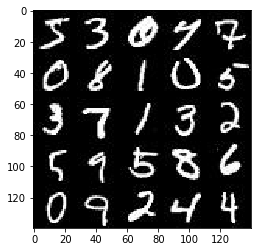

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

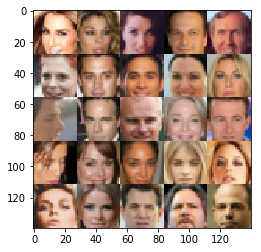

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [22]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    keep_prob = 1
    with tf.variable_scope("discriminator", reuse=reuse):        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob)
        # 7x7*128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob)
        # 4x4*256
        
        x4 = tf.layers.conv2d(x3, 512, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, keep_prob)
        # 2*2*512

        print("discriminator shape", x1.shape, x2.shape, x3.shape, x4.shape)
        # Flatten it
        flat = tf.reshape(x4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

discriminator shape (?, 14, 14, 64) (?, 7, 7, 128) (?, 4, 4, 256) (?, 2, 2, 512)
discriminator shape (?, 14, 14, 64) (?, 7, 7, 128) (?, 4, 4, 256) (?, 2, 2, 512)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [23]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    keep_prob = 1
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512)        
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4 * 4 * 512
        
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob)
        # 8 * 8 * 256
        
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob)
        # 16 * 16 * 128
        
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32 x 32 x d
        logits = tf.image.resize_images(logits, [28,28])
        
        print("generator shape", x1.shape, x2.shape, x3.shape, logits.shape)
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 5)
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)


    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)* (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

generator shape (?, 2, 2, 1024) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 4)
discriminator shape (?, 14, 14, 64) (?, 7, 7, 128) (?, 4, 4, 256)
discriminator shape (?, 14, 14, 64) (?, 7, 7, 128) (?, 4, 4, 256)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    out_channel_dim = data_shape[3]
    input_real, input_z, learning_rate_p = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_p, beta1)
    
    
    step = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images * 2
                
                step += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_p: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_p: learning_rate})

                if step % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))


                if step % 100 == 0:
                    show_generator_output(sess, 16, input_z, out_channel_dim, data_image_mode)
        show_generator_output(sess, 16, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 1)
discriminator shape (?, 14, 14, 64) (?, 7, 7, 128) (?, 4, 4, 256) (?, 2, 2, 512)
discriminator shape (?, 14, 14, 64) (?, 7, 7, 128) (?, 4, 4, 256) (?, 2, 2, 512)
Epoch 0/2... Discriminator Loss: 0.3671... Generator Loss: 5.9951
Epoch 0/2... Discriminator Loss: 0.3466... Generator Loss: 12.7031
Epoch 0/2... Discriminator Loss: 2.3237... Generator Loss: 15.7740
Epoch 0/2... Discriminator Loss: 1.5989... Generator Loss: 0.4643
Epoch 0/2... Discriminator Loss: 0.6919... Generator Loss: 1.5882
Epoch 0/2... Discriminator Loss: 0.8649... Generator Loss: 2.5957
Epoch 0/2... Discriminator Loss: 1.1623... Generator Loss: 2.6493
Epoch 0/2... Discriminator Loss: 0.4907... Generator Loss: 2.8176
Epoch 0/2... Discriminator Loss: 2.9472... Generator Loss: 6.5504
Epoch 0/2... Discriminator Loss: 0.9619... Generator Loss: 1.2363
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 1)


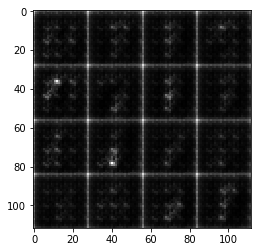

Epoch 0/2... Discriminator Loss: 0.7104... Generator Loss: 1.8923
Epoch 0/2... Discriminator Loss: 0.5826... Generator Loss: 2.0484
Epoch 0/2... Discriminator Loss: 0.6951... Generator Loss: 1.6942
Epoch 0/2... Discriminator Loss: 1.0190... Generator Loss: 3.8344
Epoch 0/2... Discriminator Loss: 0.8757... Generator Loss: 1.1344
Epoch 0/2... Discriminator Loss: 1.5305... Generator Loss: 4.9055
Epoch 0/2... Discriminator Loss: 0.7930... Generator Loss: 1.5028
Epoch 0/2... Discriminator Loss: 0.7199... Generator Loss: 1.6059
Epoch 0/2... Discriminator Loss: 0.9223... Generator Loss: 1.5893
Epoch 0/2... Discriminator Loss: 0.9854... Generator Loss: 1.9704
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 1)


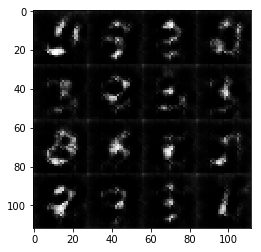

Epoch 0/2... Discriminator Loss: 0.7517... Generator Loss: 2.1306
Epoch 0/2... Discriminator Loss: 1.0119... Generator Loss: 1.0245
Epoch 0/2... Discriminator Loss: 1.6176... Generator Loss: 0.4475
Epoch 0/2... Discriminator Loss: 0.9699... Generator Loss: 0.9751
Epoch 0/2... Discriminator Loss: 0.7053... Generator Loss: 1.5864
Epoch 0/2... Discriminator Loss: 1.1227... Generator Loss: 0.7560
Epoch 0/2... Discriminator Loss: 0.7780... Generator Loss: 1.9336
Epoch 0/2... Discriminator Loss: 1.0631... Generator Loss: 0.8090
Epoch 0/2... Discriminator Loss: 0.7924... Generator Loss: 1.2472
Epoch 0/2... Discriminator Loss: 0.8731... Generator Loss: 1.1059
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 1)


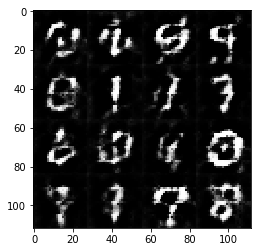

Epoch 0/2... Discriminator Loss: 0.9142... Generator Loss: 3.0055
Epoch 0/2... Discriminator Loss: 1.1009... Generator Loss: 0.8466
Epoch 0/2... Discriminator Loss: 0.6448... Generator Loss: 2.2356
Epoch 0/2... Discriminator Loss: 0.6446... Generator Loss: 1.9988
Epoch 0/2... Discriminator Loss: 0.8422... Generator Loss: 1.1607
Epoch 0/2... Discriminator Loss: 0.8659... Generator Loss: 1.0782
Epoch 0/2... Discriminator Loss: 0.6788... Generator Loss: 1.6621
Epoch 0/2... Discriminator Loss: 0.6883... Generator Loss: 1.4504
Epoch 0/2... Discriminator Loss: 0.7042... Generator Loss: 1.6429
Epoch 0/2... Discriminator Loss: 1.1593... Generator Loss: 0.7912
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 1)


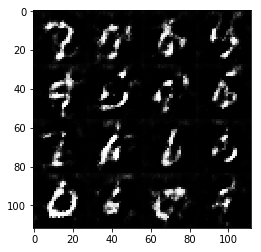

Epoch 0/2... Discriminator Loss: 0.7970... Generator Loss: 1.7471
Epoch 0/2... Discriminator Loss: 0.6775... Generator Loss: 1.6776
Epoch 0/2... Discriminator Loss: 0.7219... Generator Loss: 2.5707
Epoch 0/2... Discriminator Loss: 0.6739... Generator Loss: 1.9469
Epoch 0/2... Discriminator Loss: 0.6766... Generator Loss: 1.6352
Epoch 0/2... Discriminator Loss: 0.6284... Generator Loss: 2.0145
Epoch 0/2... Discriminator Loss: 0.8281... Generator Loss: 1.2635
Epoch 0/2... Discriminator Loss: 0.9984... Generator Loss: 0.8531
Epoch 0/2... Discriminator Loss: 0.8959... Generator Loss: 0.9972
Epoch 0/2... Discriminator Loss: 0.9284... Generator Loss: 1.0005
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 1)


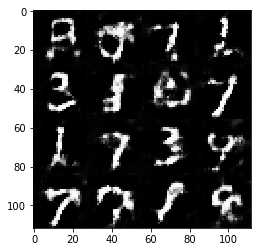

Epoch 0/2... Discriminator Loss: 1.1033... Generator Loss: 0.7211
Epoch 0/2... Discriminator Loss: 0.8251... Generator Loss: 2.1066
Epoch 0/2... Discriminator Loss: 0.6808... Generator Loss: 2.1166
Epoch 0/2... Discriminator Loss: 0.6267... Generator Loss: 1.7360
Epoch 0/2... Discriminator Loss: 1.1520... Generator Loss: 3.4332
Epoch 0/2... Discriminator Loss: 1.2819... Generator Loss: 0.6134
Epoch 0/2... Discriminator Loss: 0.9161... Generator Loss: 0.9870
Epoch 0/2... Discriminator Loss: 0.7436... Generator Loss: 1.3130
Epoch 0/2... Discriminator Loss: 0.7168... Generator Loss: 1.8171
Epoch 0/2... Discriminator Loss: 0.6809... Generator Loss: 2.4298
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 1)


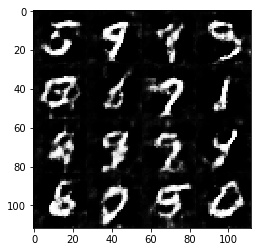

Epoch 0/2... Discriminator Loss: 0.7918... Generator Loss: 1.2595
Epoch 0/2... Discriminator Loss: 0.9294... Generator Loss: 1.0481
Epoch 0/2... Discriminator Loss: 0.7887... Generator Loss: 2.2053
Epoch 0/2... Discriminator Loss: 0.8643... Generator Loss: 1.1008
Epoch 0/2... Discriminator Loss: 0.8876... Generator Loss: 1.0283
Epoch 0/2... Discriminator Loss: 0.7819... Generator Loss: 1.2575
Epoch 0/2... Discriminator Loss: 0.7325... Generator Loss: 2.0073
Epoch 0/2... Discriminator Loss: 1.2008... Generator Loss: 0.6485
Epoch 0/2... Discriminator Loss: 0.6551... Generator Loss: 1.9964
Epoch 0/2... Discriminator Loss: 0.8276... Generator Loss: 1.2797
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 1)


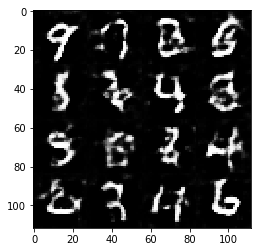

Epoch 0/2... Discriminator Loss: 0.7922... Generator Loss: 1.3262
Epoch 0/2... Discriminator Loss: 0.7866... Generator Loss: 1.2556
Epoch 0/2... Discriminator Loss: 0.7666... Generator Loss: 2.1615
Epoch 0/2... Discriminator Loss: 0.8107... Generator Loss: 1.1990
Epoch 0/2... Discriminator Loss: 0.6356... Generator Loss: 1.5525
Epoch 0/2... Discriminator Loss: 0.6239... Generator Loss: 1.9771
Epoch 0/2... Discriminator Loss: 0.6716... Generator Loss: 1.7683
Epoch 0/2... Discriminator Loss: 1.2524... Generator Loss: 0.6374
Epoch 0/2... Discriminator Loss: 0.9398... Generator Loss: 0.9231
Epoch 0/2... Discriminator Loss: 1.5646... Generator Loss: 0.4724
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 1)


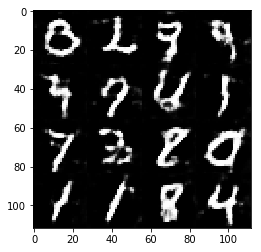

Epoch 0/2... Discriminator Loss: 0.6036... Generator Loss: 1.7727
Epoch 0/2... Discriminator Loss: 0.8941... Generator Loss: 0.9823
Epoch 0/2... Discriminator Loss: 1.0359... Generator Loss: 3.9522
Epoch 0/2... Discriminator Loss: 0.5099... Generator Loss: 2.3671
Epoch 0/2... Discriminator Loss: 0.6909... Generator Loss: 2.6890
Epoch 0/2... Discriminator Loss: 0.9693... Generator Loss: 1.0398
Epoch 0/2... Discriminator Loss: 0.8606... Generator Loss: 1.1590
Epoch 0/2... Discriminator Loss: 0.7005... Generator Loss: 1.3697
Epoch 0/2... Discriminator Loss: 0.7511... Generator Loss: 1.7980
Epoch 0/2... Discriminator Loss: 0.7159... Generator Loss: 1.3258
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 1)


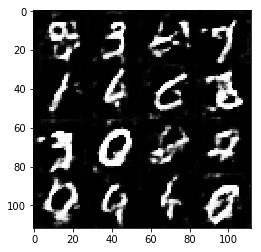

Epoch 0/2... Discriminator Loss: 0.7641... Generator Loss: 1.2105
Epoch 0/2... Discriminator Loss: 0.6273... Generator Loss: 1.6876
Epoch 0/2... Discriminator Loss: 0.8356... Generator Loss: 1.0626
Epoch 1/2... Discriminator Loss: 0.7189... Generator Loss: 1.2761
Epoch 1/2... Discriminator Loss: 1.4261... Generator Loss: 0.6276
Epoch 1/2... Discriminator Loss: 0.8578... Generator Loss: 1.1990
Epoch 1/2... Discriminator Loss: 0.7451... Generator Loss: 1.3711
Epoch 1/2... Discriminator Loss: 0.7072... Generator Loss: 1.5211
Epoch 1/2... Discriminator Loss: 1.0104... Generator Loss: 0.8939
Epoch 1/2... Discriminator Loss: 0.7921... Generator Loss: 1.2806
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 1)


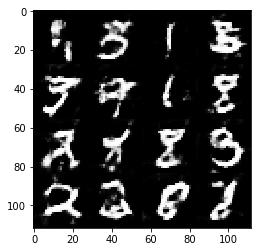

Epoch 1/2... Discriminator Loss: 0.5860... Generator Loss: 1.7418
Epoch 1/2... Discriminator Loss: 0.6202... Generator Loss: 1.5583
Epoch 1/2... Discriminator Loss: 0.6841... Generator Loss: 1.5305
Epoch 1/2... Discriminator Loss: 0.7640... Generator Loss: 1.2167
Epoch 1/2... Discriminator Loss: 0.6924... Generator Loss: 1.4925
Epoch 1/2... Discriminator Loss: 1.4356... Generator Loss: 0.5633
Epoch 1/2... Discriminator Loss: 0.8435... Generator Loss: 2.1441
Epoch 1/2... Discriminator Loss: 0.6729... Generator Loss: 1.5839
Epoch 1/2... Discriminator Loss: 0.6416... Generator Loss: 1.6094
Epoch 1/2... Discriminator Loss: 0.8615... Generator Loss: 1.0897
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 1)


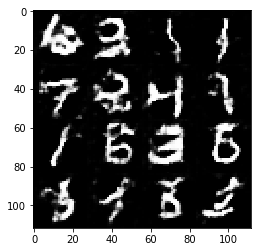

Epoch 1/2... Discriminator Loss: 0.6555... Generator Loss: 1.4560
Epoch 1/2... Discriminator Loss: 0.8053... Generator Loss: 1.1065
Epoch 1/2... Discriminator Loss: 0.5249... Generator Loss: 1.9653
Epoch 1/2... Discriminator Loss: 0.6661... Generator Loss: 1.4117
Epoch 1/2... Discriminator Loss: 0.9495... Generator Loss: 1.7730
Epoch 1/2... Discriminator Loss: 0.7624... Generator Loss: 1.1514
Epoch 1/2... Discriminator Loss: 0.8751... Generator Loss: 0.9669
Epoch 1/2... Discriminator Loss: 2.1930... Generator Loss: 0.2626
Epoch 1/2... Discriminator Loss: 0.7851... Generator Loss: 1.1651
Epoch 1/2... Discriminator Loss: 0.6968... Generator Loss: 1.4050
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 1)


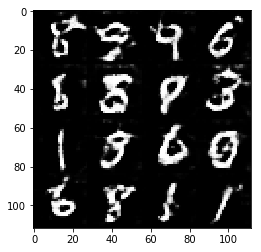

Epoch 1/2... Discriminator Loss: 0.7427... Generator Loss: 1.2770
Epoch 1/2... Discriminator Loss: 0.6323... Generator Loss: 1.6275
Epoch 1/2... Discriminator Loss: 1.2263... Generator Loss: 0.6148
Epoch 1/2... Discriminator Loss: 0.7966... Generator Loss: 1.0917
Epoch 1/2... Discriminator Loss: 1.6973... Generator Loss: 2.7385
Epoch 1/2... Discriminator Loss: 1.2276... Generator Loss: 3.1135
Epoch 1/2... Discriminator Loss: 0.8445... Generator Loss: 1.0653
Epoch 1/2... Discriminator Loss: 2.0524... Generator Loss: 0.2806
Epoch 1/2... Discriminator Loss: 0.8222... Generator Loss: 2.2285
Epoch 1/2... Discriminator Loss: 0.7411... Generator Loss: 1.2398
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 1)


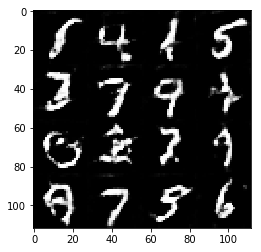

Epoch 1/2... Discriminator Loss: 0.6971... Generator Loss: 1.3214
Epoch 1/2... Discriminator Loss: 0.8348... Generator Loss: 1.8940
Epoch 1/2... Discriminator Loss: 0.6829... Generator Loss: 1.4016
Epoch 1/2... Discriminator Loss: 0.6299... Generator Loss: 1.8127
Epoch 1/2... Discriminator Loss: 1.0124... Generator Loss: 0.8725
Epoch 1/2... Discriminator Loss: 1.4814... Generator Loss: 0.5141
Epoch 1/2... Discriminator Loss: 0.5954... Generator Loss: 1.9249
Epoch 1/2... Discriminator Loss: 1.3926... Generator Loss: 0.5561
Epoch 1/2... Discriminator Loss: 0.7849... Generator Loss: 1.7341
Epoch 1/2... Discriminator Loss: 0.7560... Generator Loss: 1.4778
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 1)


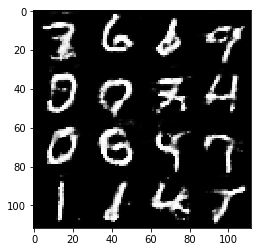

Epoch 1/2... Discriminator Loss: 0.6880... Generator Loss: 1.6898
Epoch 1/2... Discriminator Loss: 0.8382... Generator Loss: 1.0691
Epoch 1/2... Discriminator Loss: 1.1317... Generator Loss: 0.6985
Epoch 1/2... Discriminator Loss: 0.6786... Generator Loss: 1.4395
Epoch 1/2... Discriminator Loss: 0.6943... Generator Loss: 1.4045
Epoch 1/2... Discriminator Loss: 0.7661... Generator Loss: 1.2768
Epoch 1/2... Discriminator Loss: 0.7127... Generator Loss: 1.2917
Epoch 1/2... Discriminator Loss: 0.9306... Generator Loss: 0.8898
Epoch 1/2... Discriminator Loss: 0.8778... Generator Loss: 2.5999
Epoch 1/2... Discriminator Loss: 0.6120... Generator Loss: 2.2801
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 1)


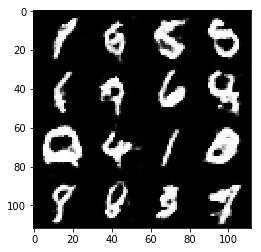

Epoch 1/2... Discriminator Loss: 0.7383... Generator Loss: 1.2447
Epoch 1/2... Discriminator Loss: 0.7019... Generator Loss: 1.3357
Epoch 1/2... Discriminator Loss: 0.4986... Generator Loss: 2.1147
Epoch 1/2... Discriminator Loss: 0.6712... Generator Loss: 1.6365
Epoch 1/2... Discriminator Loss: 0.5415... Generator Loss: 1.8518
Epoch 1/2... Discriminator Loss: 0.7357... Generator Loss: 2.7685
Epoch 1/2... Discriminator Loss: 1.1486... Generator Loss: 0.7595
Epoch 1/2... Discriminator Loss: 0.7045... Generator Loss: 1.2932
Epoch 1/2... Discriminator Loss: 1.0789... Generator Loss: 0.7457
Epoch 1/2... Discriminator Loss: 0.7261... Generator Loss: 1.3089
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 1)


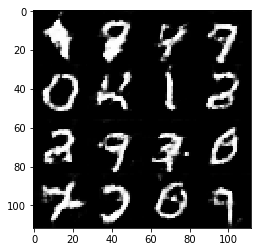

Epoch 1/2... Discriminator Loss: 1.3013... Generator Loss: 2.6697
Epoch 1/2... Discriminator Loss: 0.8357... Generator Loss: 1.0862
Epoch 1/2... Discriminator Loss: 1.3092... Generator Loss: 0.7828
Epoch 1/2... Discriminator Loss: 1.7051... Generator Loss: 0.4488
Epoch 1/2... Discriminator Loss: 0.7695... Generator Loss: 2.3369
Epoch 1/2... Discriminator Loss: 1.0628... Generator Loss: 0.8086
Epoch 1/2... Discriminator Loss: 0.5616... Generator Loss: 2.0130
Epoch 1/2... Discriminator Loss: 0.5782... Generator Loss: 1.7023
Epoch 1/2... Discriminator Loss: 0.4818... Generator Loss: 2.1792
Epoch 1/2... Discriminator Loss: 1.4527... Generator Loss: 0.4998
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 1)


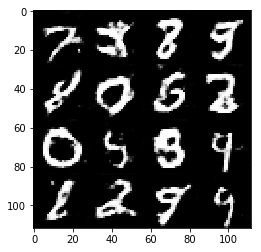

Epoch 1/2... Discriminator Loss: 0.6658... Generator Loss: 1.5533
Epoch 1/2... Discriminator Loss: 1.0395... Generator Loss: 0.8231
Epoch 1/2... Discriminator Loss: 1.5649... Generator Loss: 0.4859
Epoch 1/2... Discriminator Loss: 0.6336... Generator Loss: 1.6932
Epoch 1/2... Discriminator Loss: 0.7337... Generator Loss: 1.2808
Epoch 1/2... Discriminator Loss: 0.4925... Generator Loss: 2.1565
Epoch 1/2... Discriminator Loss: 0.9121... Generator Loss: 0.9409
Epoch 1/2... Discriminator Loss: 0.5902... Generator Loss: 1.8891
Epoch 1/2... Discriminator Loss: 0.5754... Generator Loss: 1.7558
Epoch 1/2... Discriminator Loss: 0.8784... Generator Loss: 2.1351
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 1)


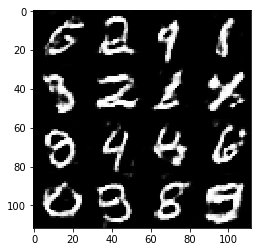

Epoch 1/2... Discriminator Loss: 0.8137... Generator Loss: 1.1362
Epoch 1/2... Discriminator Loss: 0.6746... Generator Loss: 1.4971
Epoch 1/2... Discriminator Loss: 0.7622... Generator Loss: 1.2452
Epoch 1/2... Discriminator Loss: 0.7619... Generator Loss: 1.2307
Epoch 1/2... Discriminator Loss: 1.0685... Generator Loss: 2.0137
Epoch 1/2... Discriminator Loss: 0.7740... Generator Loss: 1.1661
Epoch 1/2... Discriminator Loss: 0.7961... Generator Loss: 1.0999
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 1)


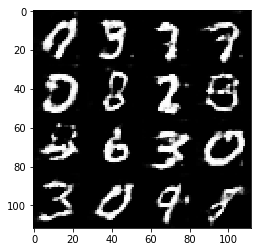

In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)
discriminator shape (?, 14, 14, 64) (?, 7, 7, 128) (?, 4, 4, 256) (?, 2, 2, 512)
discriminator shape (?, 14, 14, 64) (?, 7, 7, 128) (?, 4, 4, 256) (?, 2, 2, 512)
Epoch 0/1... Discriminator Loss: 0.5128... Generator Loss: 6.2262
Epoch 0/1... Discriminator Loss: 0.5016... Generator Loss: 16.1802
Epoch 0/1... Discriminator Loss: 0.7790... Generator Loss: 13.8415
Epoch 0/1... Discriminator Loss: 0.4663... Generator Loss: 3.5589
Epoch 0/1... Discriminator Loss: 0.4054... Generator Loss: 4.1612
Epoch 0/1... Discriminator Loss: 0.8260... Generator Loss: 3.6379
Epoch 0/1... Discriminator Loss: 1.2919... Generator Loss: 1.4934
Epoch 0/1... Discriminator Loss: 1.2770... Generator Loss: 0.6919
Epoch 0/1... Discriminator Loss: 1.5318... Generator Loss: 0.4486
Epoch 0/1... Discriminator Loss: 1.1475... Generator Loss: 0.9463
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


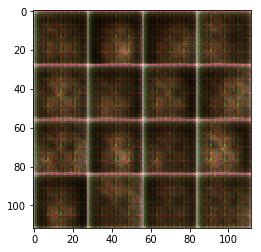

Epoch 0/1... Discriminator Loss: 0.9879... Generator Loss: 1.1061
Epoch 0/1... Discriminator Loss: 0.8143... Generator Loss: 1.1435
Epoch 0/1... Discriminator Loss: 0.8831... Generator Loss: 1.1267
Epoch 0/1... Discriminator Loss: 1.3684... Generator Loss: 2.9615
Epoch 0/1... Discriminator Loss: 1.0223... Generator Loss: 1.1548
Epoch 0/1... Discriminator Loss: 1.0722... Generator Loss: 0.8509
Epoch 0/1... Discriminator Loss: 0.8685... Generator Loss: 1.5783
Epoch 0/1... Discriminator Loss: 1.0608... Generator Loss: 0.8543
Epoch 0/1... Discriminator Loss: 0.8177... Generator Loss: 1.5407
Epoch 0/1... Discriminator Loss: 0.9391... Generator Loss: 1.2295
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


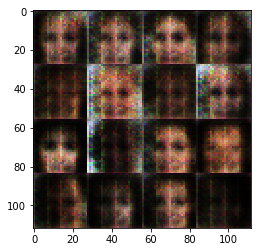

Epoch 0/1... Discriminator Loss: 0.9652... Generator Loss: 1.3968
Epoch 0/1... Discriminator Loss: 0.9716... Generator Loss: 2.3280
Epoch 0/1... Discriminator Loss: 0.9583... Generator Loss: 0.9902
Epoch 0/1... Discriminator Loss: 0.8985... Generator Loss: 0.9804
Epoch 0/1... Discriminator Loss: 0.7926... Generator Loss: 1.2443
Epoch 0/1... Discriminator Loss: 1.4860... Generator Loss: 0.9828
Epoch 0/1... Discriminator Loss: 1.7230... Generator Loss: 2.6407
Epoch 0/1... Discriminator Loss: 1.2065... Generator Loss: 1.3127
Epoch 0/1... Discriminator Loss: 1.4413... Generator Loss: 1.9315
Epoch 0/1... Discriminator Loss: 1.3369... Generator Loss: 0.6798
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


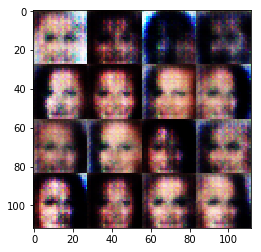

Epoch 0/1... Discriminator Loss: 1.4518... Generator Loss: 0.8958
Epoch 0/1... Discriminator Loss: 1.2071... Generator Loss: 1.8332
Epoch 0/1... Discriminator Loss: 1.2698... Generator Loss: 0.7412
Epoch 0/1... Discriminator Loss: 1.1766... Generator Loss: 2.1013
Epoch 0/1... Discriminator Loss: 1.1908... Generator Loss: 0.6966
Epoch 0/1... Discriminator Loss: 1.0206... Generator Loss: 1.0329
Epoch 0/1... Discriminator Loss: 1.0531... Generator Loss: 1.0732
Epoch 0/1... Discriminator Loss: 1.3808... Generator Loss: 0.6054
Epoch 0/1... Discriminator Loss: 1.1443... Generator Loss: 1.5470
Epoch 0/1... Discriminator Loss: 1.1716... Generator Loss: 1.0179
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


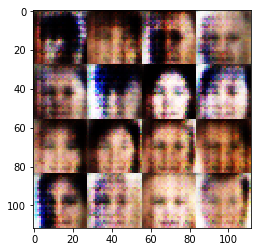

Epoch 0/1... Discriminator Loss: 0.9695... Generator Loss: 1.6553
Epoch 0/1... Discriminator Loss: 1.1558... Generator Loss: 0.8954
Epoch 0/1... Discriminator Loss: 0.9463... Generator Loss: 1.7163
Epoch 0/1... Discriminator Loss: 1.0617... Generator Loss: 0.9147
Epoch 0/1... Discriminator Loss: 1.1939... Generator Loss: 1.6550
Epoch 0/1... Discriminator Loss: 1.0025... Generator Loss: 1.0791
Epoch 0/1... Discriminator Loss: 1.0659... Generator Loss: 1.9723
Epoch 0/1... Discriminator Loss: 1.0529... Generator Loss: 1.1711
Epoch 0/1... Discriminator Loss: 1.0077... Generator Loss: 1.6044
Epoch 0/1... Discriminator Loss: 1.0954... Generator Loss: 0.8549
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


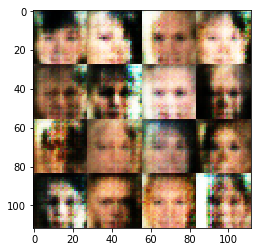

Epoch 0/1... Discriminator Loss: 1.1225... Generator Loss: 1.1388
Epoch 0/1... Discriminator Loss: 1.0411... Generator Loss: 1.0651
Epoch 0/1... Discriminator Loss: 0.8953... Generator Loss: 1.0510
Epoch 0/1... Discriminator Loss: 1.2919... Generator Loss: 0.9242
Epoch 0/1... Discriminator Loss: 1.0526... Generator Loss: 1.0738
Epoch 0/1... Discriminator Loss: 0.9954... Generator Loss: 0.9324
Epoch 0/1... Discriminator Loss: 1.4701... Generator Loss: 2.4278
Epoch 0/1... Discriminator Loss: 1.0424... Generator Loss: 0.9165
Epoch 0/1... Discriminator Loss: 1.2866... Generator Loss: 0.5897
Epoch 0/1... Discriminator Loss: 1.0450... Generator Loss: 0.8848
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


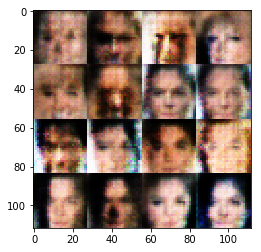

Epoch 0/1... Discriminator Loss: 0.9062... Generator Loss: 1.3030
Epoch 0/1... Discriminator Loss: 1.3664... Generator Loss: 2.8169
Epoch 0/1... Discriminator Loss: 0.9585... Generator Loss: 1.4781
Epoch 0/1... Discriminator Loss: 1.2094... Generator Loss: 1.1944
Epoch 0/1... Discriminator Loss: 1.0553... Generator Loss: 1.2806
Epoch 0/1... Discriminator Loss: 1.0040... Generator Loss: 0.8987
Epoch 0/1... Discriminator Loss: 0.9143... Generator Loss: 1.4624
Epoch 0/1... Discriminator Loss: 1.1026... Generator Loss: 1.6800
Epoch 0/1... Discriminator Loss: 1.0398... Generator Loss: 1.0339
Epoch 0/1... Discriminator Loss: 1.1042... Generator Loss: 1.4874
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


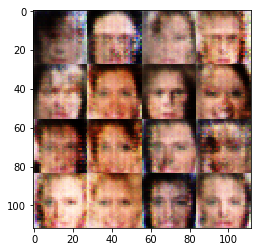

Epoch 0/1... Discriminator Loss: 1.0634... Generator Loss: 1.2369
Epoch 0/1... Discriminator Loss: 1.5365... Generator Loss: 2.3477
Epoch 0/1... Discriminator Loss: 1.2248... Generator Loss: 0.7217
Epoch 0/1... Discriminator Loss: 1.0138... Generator Loss: 1.8934
Epoch 0/1... Discriminator Loss: 1.0236... Generator Loss: 1.1578
Epoch 0/1... Discriminator Loss: 1.2902... Generator Loss: 0.6378
Epoch 0/1... Discriminator Loss: 0.9586... Generator Loss: 1.1221
Epoch 0/1... Discriminator Loss: 1.0425... Generator Loss: 0.7900
Epoch 0/1... Discriminator Loss: 1.1040... Generator Loss: 1.1625
Epoch 0/1... Discriminator Loss: 0.9607... Generator Loss: 1.2785
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


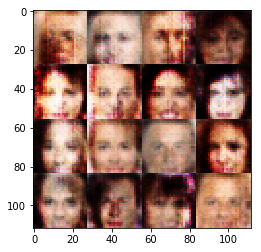

Epoch 0/1... Discriminator Loss: 1.0214... Generator Loss: 1.2995
Epoch 0/1... Discriminator Loss: 1.3169... Generator Loss: 0.5756
Epoch 0/1... Discriminator Loss: 1.1564... Generator Loss: 0.6947
Epoch 0/1... Discriminator Loss: 1.2446... Generator Loss: 0.6257
Epoch 0/1... Discriminator Loss: 1.0461... Generator Loss: 0.8918
Epoch 0/1... Discriminator Loss: 0.8668... Generator Loss: 1.3472
Epoch 0/1... Discriminator Loss: 1.0198... Generator Loss: 1.7520
Epoch 0/1... Discriminator Loss: 1.0452... Generator Loss: 0.9428
Epoch 0/1... Discriminator Loss: 1.0680... Generator Loss: 1.8136
Epoch 0/1... Discriminator Loss: 1.4006... Generator Loss: 0.5551
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


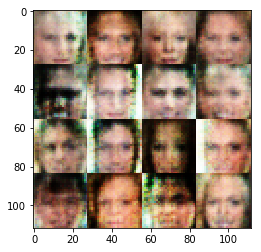

Epoch 0/1... Discriminator Loss: 1.0738... Generator Loss: 0.9628
Epoch 0/1... Discriminator Loss: 1.0354... Generator Loss: 1.2473
Epoch 0/1... Discriminator Loss: 0.9165... Generator Loss: 1.2879
Epoch 0/1... Discriminator Loss: 0.9950... Generator Loss: 1.1440
Epoch 0/1... Discriminator Loss: 0.9544... Generator Loss: 1.0171
Epoch 0/1... Discriminator Loss: 1.0620... Generator Loss: 0.8504
Epoch 0/1... Discriminator Loss: 1.0598... Generator Loss: 1.9114
Epoch 0/1... Discriminator Loss: 0.9984... Generator Loss: 0.8762
Epoch 0/1... Discriminator Loss: 1.0288... Generator Loss: 1.3692
Epoch 0/1... Discriminator Loss: 0.9411... Generator Loss: 1.1097
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


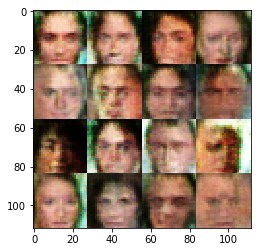

Epoch 0/1... Discriminator Loss: 0.9078... Generator Loss: 1.6804
Epoch 0/1... Discriminator Loss: 1.0211... Generator Loss: 0.8592
Epoch 0/1... Discriminator Loss: 1.1546... Generator Loss: 0.6828
Epoch 0/1... Discriminator Loss: 0.8656... Generator Loss: 1.5719
Epoch 0/1... Discriminator Loss: 0.9746... Generator Loss: 1.5307
Epoch 0/1... Discriminator Loss: 0.9905... Generator Loss: 1.2119
Epoch 0/1... Discriminator Loss: 0.9353... Generator Loss: 1.2338
Epoch 0/1... Discriminator Loss: 1.2730... Generator Loss: 0.6572
Epoch 0/1... Discriminator Loss: 1.0382... Generator Loss: 1.4184
Epoch 0/1... Discriminator Loss: 1.2730... Generator Loss: 0.8911
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


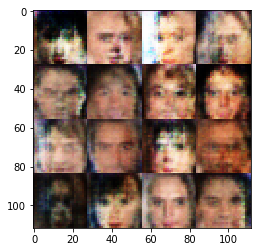

Epoch 0/1... Discriminator Loss: 1.2379... Generator Loss: 0.6411
Epoch 0/1... Discriminator Loss: 1.0822... Generator Loss: 0.8183
Epoch 0/1... Discriminator Loss: 0.9194... Generator Loss: 1.2950
Epoch 0/1... Discriminator Loss: 1.1722... Generator Loss: 0.6718
Epoch 0/1... Discriminator Loss: 0.9284... Generator Loss: 1.5854
Epoch 0/1... Discriminator Loss: 0.9561... Generator Loss: 1.1590
Epoch 0/1... Discriminator Loss: 1.0883... Generator Loss: 0.7452
Epoch 0/1... Discriminator Loss: 1.2521... Generator Loss: 0.6343
Epoch 0/1... Discriminator Loss: 1.2034... Generator Loss: 0.7112
Epoch 0/1... Discriminator Loss: 1.0473... Generator Loss: 0.8512
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


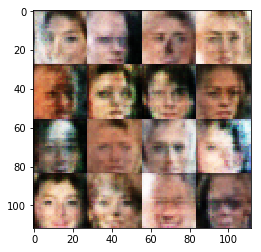

Epoch 0/1... Discriminator Loss: 1.0932... Generator Loss: 0.8243
Epoch 0/1... Discriminator Loss: 0.9428... Generator Loss: 1.0431
Epoch 0/1... Discriminator Loss: 1.0877... Generator Loss: 2.0694
Epoch 0/1... Discriminator Loss: 1.0549... Generator Loss: 1.2338
Epoch 0/1... Discriminator Loss: 1.2064... Generator Loss: 0.6269
Epoch 0/1... Discriminator Loss: 1.2883... Generator Loss: 0.5799
Epoch 0/1... Discriminator Loss: 1.1338... Generator Loss: 0.9053
Epoch 0/1... Discriminator Loss: 1.0500... Generator Loss: 0.8376
Epoch 0/1... Discriminator Loss: 1.1984... Generator Loss: 1.0939
Epoch 0/1... Discriminator Loss: 1.1193... Generator Loss: 0.7482
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


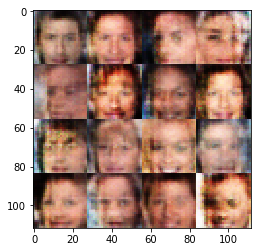

Epoch 0/1... Discriminator Loss: 1.0074... Generator Loss: 0.9112
Epoch 0/1... Discriminator Loss: 1.1067... Generator Loss: 0.7619
Epoch 0/1... Discriminator Loss: 1.1087... Generator Loss: 0.7615
Epoch 0/1... Discriminator Loss: 1.2888... Generator Loss: 0.7752
Epoch 0/1... Discriminator Loss: 1.3289... Generator Loss: 0.5571
Epoch 0/1... Discriminator Loss: 0.8563... Generator Loss: 1.4052
Epoch 0/1... Discriminator Loss: 1.0950... Generator Loss: 0.8241
Epoch 0/1... Discriminator Loss: 1.1472... Generator Loss: 0.7644
Epoch 0/1... Discriminator Loss: 1.1547... Generator Loss: 0.7019
Epoch 0/1... Discriminator Loss: 1.0896... Generator Loss: 0.7520
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


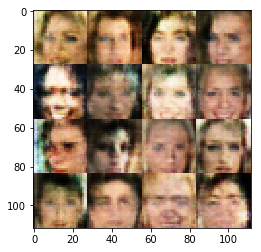

Epoch 0/1... Discriminator Loss: 1.1027... Generator Loss: 0.7376
Epoch 0/1... Discriminator Loss: 1.0614... Generator Loss: 1.1857
Epoch 0/1... Discriminator Loss: 1.1092... Generator Loss: 0.7940
Epoch 0/1... Discriminator Loss: 0.9124... Generator Loss: 1.2913
Epoch 0/1... Discriminator Loss: 0.9408... Generator Loss: 1.0136
Epoch 0/1... Discriminator Loss: 0.9498... Generator Loss: 1.7477
Epoch 0/1... Discriminator Loss: 0.9743... Generator Loss: 1.8698
Epoch 0/1... Discriminator Loss: 1.2669... Generator Loss: 0.6123
Epoch 0/1... Discriminator Loss: 1.1638... Generator Loss: 0.7252
Epoch 0/1... Discriminator Loss: 1.0217... Generator Loss: 0.8481
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


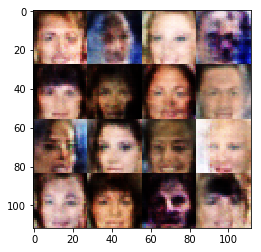

Epoch 0/1... Discriminator Loss: 1.2431... Generator Loss: 0.6835
Epoch 0/1... Discriminator Loss: 0.7864... Generator Loss: 1.2932
Epoch 0/1... Discriminator Loss: 1.1087... Generator Loss: 0.7389
Epoch 0/1... Discriminator Loss: 0.8392... Generator Loss: 1.2057
Epoch 0/1... Discriminator Loss: 1.2696... Generator Loss: 0.6116
Epoch 0/1... Discriminator Loss: 0.9402... Generator Loss: 1.5435
Epoch 0/1... Discriminator Loss: 0.9782... Generator Loss: 1.0226
Epoch 0/1... Discriminator Loss: 1.2460... Generator Loss: 0.5866
Epoch 0/1... Discriminator Loss: 1.1502... Generator Loss: 0.6977
Epoch 0/1... Discriminator Loss: 0.8623... Generator Loss: 1.5505
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


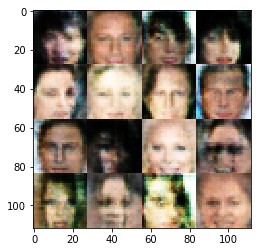

Epoch 0/1... Discriminator Loss: 0.8672... Generator Loss: 1.3484
Epoch 0/1... Discriminator Loss: 0.8889... Generator Loss: 1.3703
Epoch 0/1... Discriminator Loss: 0.8577... Generator Loss: 1.1676
Epoch 0/1... Discriminator Loss: 1.2239... Generator Loss: 0.6492
Epoch 0/1... Discriminator Loss: 0.8986... Generator Loss: 0.9901
Epoch 0/1... Discriminator Loss: 1.3564... Generator Loss: 0.5387
Epoch 0/1... Discriminator Loss: 0.9722... Generator Loss: 0.9121
Epoch 0/1... Discriminator Loss: 0.9528... Generator Loss: 1.0026
Epoch 0/1... Discriminator Loss: 0.8825... Generator Loss: 1.1014
Epoch 0/1... Discriminator Loss: 1.0766... Generator Loss: 0.8776
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


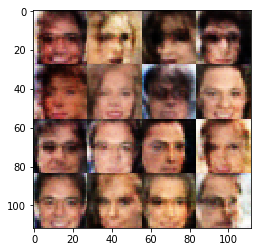

Epoch 0/1... Discriminator Loss: 1.0267... Generator Loss: 1.6439
Epoch 0/1... Discriminator Loss: 0.9359... Generator Loss: 1.0533
Epoch 0/1... Discriminator Loss: 0.8681... Generator Loss: 1.8494
Epoch 0/1... Discriminator Loss: 1.0532... Generator Loss: 1.5820
Epoch 0/1... Discriminator Loss: 1.0453... Generator Loss: 1.5673
Epoch 0/1... Discriminator Loss: 1.0607... Generator Loss: 1.0172
Epoch 0/1... Discriminator Loss: 1.1138... Generator Loss: 2.4196
Epoch 0/1... Discriminator Loss: 0.9068... Generator Loss: 1.3647
Epoch 0/1... Discriminator Loss: 0.9762... Generator Loss: 0.9517
Epoch 0/1... Discriminator Loss: 1.1019... Generator Loss: 0.7951
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


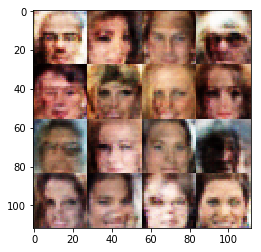

Epoch 0/1... Discriminator Loss: 0.9660... Generator Loss: 1.0637
Epoch 0/1... Discriminator Loss: 1.0919... Generator Loss: 0.7789
Epoch 0/1... Discriminator Loss: 0.9638... Generator Loss: 1.6684
Epoch 0/1... Discriminator Loss: 1.0458... Generator Loss: 0.9079
Epoch 0/1... Discriminator Loss: 0.8928... Generator Loss: 1.2216
Epoch 0/1... Discriminator Loss: 0.7640... Generator Loss: 1.5404
Epoch 0/1... Discriminator Loss: 1.3150... Generator Loss: 0.5537
Epoch 0/1... Discriminator Loss: 0.9650... Generator Loss: 0.9736
Epoch 0/1... Discriminator Loss: 1.0258... Generator Loss: 0.7903
Epoch 0/1... Discriminator Loss: 0.9089... Generator Loss: 1.3044
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


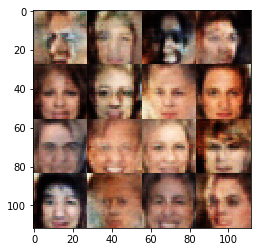

Epoch 0/1... Discriminator Loss: 0.9073... Generator Loss: 1.3349
Epoch 0/1... Discriminator Loss: 1.3283... Generator Loss: 0.5508
Epoch 0/1... Discriminator Loss: 0.9715... Generator Loss: 0.9411
Epoch 0/1... Discriminator Loss: 1.0869... Generator Loss: 0.7990
Epoch 0/1... Discriminator Loss: 1.0467... Generator Loss: 1.1817
Epoch 0/1... Discriminator Loss: 0.9873... Generator Loss: 1.5305
Epoch 0/1... Discriminator Loss: 1.0777... Generator Loss: 0.8338
Epoch 0/1... Discriminator Loss: 1.1973... Generator Loss: 0.6143
Epoch 0/1... Discriminator Loss: 1.1535... Generator Loss: 0.6994
Epoch 0/1... Discriminator Loss: 1.1947... Generator Loss: 0.6563
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


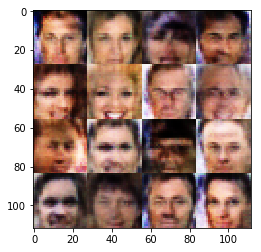

Epoch 0/1... Discriminator Loss: 1.4364... Generator Loss: 0.5099
Epoch 0/1... Discriminator Loss: 1.0250... Generator Loss: 0.8840
Epoch 0/1... Discriminator Loss: 0.8039... Generator Loss: 1.2747
Epoch 0/1... Discriminator Loss: 1.3487... Generator Loss: 0.5130
Epoch 0/1... Discriminator Loss: 1.0482... Generator Loss: 1.9479
Epoch 0/1... Discriminator Loss: 0.9302... Generator Loss: 1.1941
Epoch 0/1... Discriminator Loss: 1.3496... Generator Loss: 0.5669
Epoch 0/1... Discriminator Loss: 0.8658... Generator Loss: 1.2491
Epoch 0/1... Discriminator Loss: 0.9572... Generator Loss: 0.9701
Epoch 0/1... Discriminator Loss: 0.8986... Generator Loss: 1.0758
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


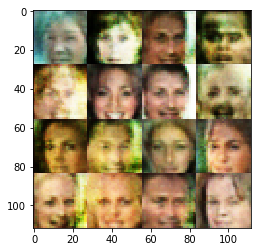

Epoch 0/1... Discriminator Loss: 1.0132... Generator Loss: 1.0746
Epoch 0/1... Discriminator Loss: 1.2269... Generator Loss: 0.6540
Epoch 0/1... Discriminator Loss: 0.9640... Generator Loss: 0.8786
Epoch 0/1... Discriminator Loss: 1.0308... Generator Loss: 0.9554
Epoch 0/1... Discriminator Loss: 0.9571... Generator Loss: 1.8702
Epoch 0/1... Discriminator Loss: 0.9498... Generator Loss: 1.0264
Epoch 0/1... Discriminator Loss: 1.1103... Generator Loss: 0.7478
Epoch 0/1... Discriminator Loss: 0.8877... Generator Loss: 1.1983
Epoch 0/1... Discriminator Loss: 0.9354... Generator Loss: 1.0792
Epoch 0/1... Discriminator Loss: 0.9947... Generator Loss: 1.4319
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


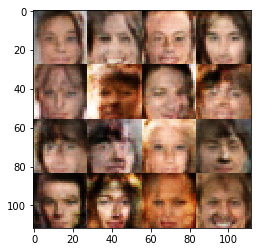

Epoch 0/1... Discriminator Loss: 0.9987... Generator Loss: 1.3434
Epoch 0/1... Discriminator Loss: 0.9313... Generator Loss: 0.9287
Epoch 0/1... Discriminator Loss: 1.4641... Generator Loss: 2.8050
Epoch 0/1... Discriminator Loss: 0.9668... Generator Loss: 1.1206
Epoch 0/1... Discriminator Loss: 1.0732... Generator Loss: 1.0943
Epoch 0/1... Discriminator Loss: 1.0054... Generator Loss: 0.9325
Epoch 0/1... Discriminator Loss: 1.0342... Generator Loss: 0.8233
Epoch 0/1... Discriminator Loss: 0.9638... Generator Loss: 1.3013
Epoch 0/1... Discriminator Loss: 0.8081... Generator Loss: 1.4086
Epoch 0/1... Discriminator Loss: 0.9590... Generator Loss: 2.9378
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


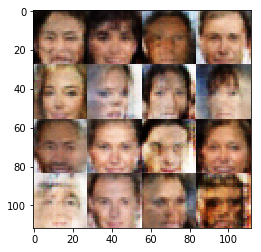

Epoch 0/1... Discriminator Loss: 1.1473... Generator Loss: 0.6819
Epoch 0/1... Discriminator Loss: 0.9702... Generator Loss: 0.8737
Epoch 0/1... Discriminator Loss: 1.0203... Generator Loss: 0.8872
Epoch 0/1... Discriminator Loss: 1.9391... Generator Loss: 0.2657
Epoch 0/1... Discriminator Loss: 1.2823... Generator Loss: 0.5888
Epoch 0/1... Discriminator Loss: 0.9791... Generator Loss: 1.0682
Epoch 0/1... Discriminator Loss: 0.9769... Generator Loss: 1.0473
Epoch 0/1... Discriminator Loss: 1.0214... Generator Loss: 0.8429
Epoch 0/1... Discriminator Loss: 1.1039... Generator Loss: 0.8107
Epoch 0/1... Discriminator Loss: 0.9950... Generator Loss: 0.9023
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


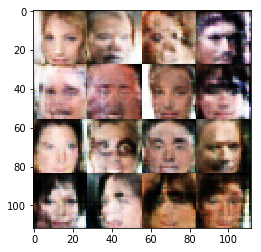

Epoch 0/1... Discriminator Loss: 1.1573... Generator Loss: 0.6434
Epoch 0/1... Discriminator Loss: 1.8784... Generator Loss: 0.2728
Epoch 0/1... Discriminator Loss: 0.9189... Generator Loss: 1.1578
Epoch 0/1... Discriminator Loss: 1.1174... Generator Loss: 0.7489
Epoch 0/1... Discriminator Loss: 1.0493... Generator Loss: 1.3159
Epoch 0/1... Discriminator Loss: 1.3130... Generator Loss: 0.6124
Epoch 0/1... Discriminator Loss: 1.0206... Generator Loss: 0.8767
Epoch 0/1... Discriminator Loss: 0.9488... Generator Loss: 1.0625
Epoch 0/1... Discriminator Loss: 0.7516... Generator Loss: 1.7569
Epoch 0/1... Discriminator Loss: 1.1877... Generator Loss: 0.6370
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


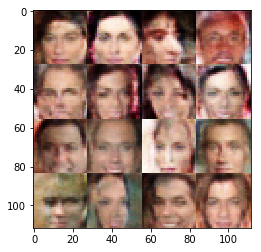

Epoch 0/1... Discriminator Loss: 1.1197... Generator Loss: 0.7112
Epoch 0/1... Discriminator Loss: 1.4101... Generator Loss: 0.4824
Epoch 0/1... Discriminator Loss: 1.0418... Generator Loss: 0.8538
Epoch 0/1... Discriminator Loss: 0.9900... Generator Loss: 0.9994
Epoch 0/1... Discriminator Loss: 0.9961... Generator Loss: 0.9847
Epoch 0/1... Discriminator Loss: 1.1248... Generator Loss: 0.7915
Epoch 0/1... Discriminator Loss: 1.0454... Generator Loss: 0.7891
Epoch 0/1... Discriminator Loss: 0.8502... Generator Loss: 1.1769
Epoch 0/1... Discriminator Loss: 1.0781... Generator Loss: 0.9404
Epoch 0/1... Discriminator Loss: 1.1076... Generator Loss: 0.7346
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


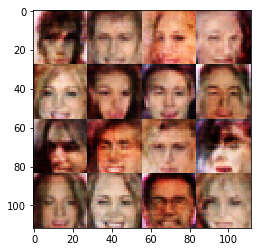

Epoch 0/1... Discriminator Loss: 0.8322... Generator Loss: 1.4814
Epoch 0/1... Discriminator Loss: 1.0938... Generator Loss: 0.7653
Epoch 0/1... Discriminator Loss: 0.9271... Generator Loss: 1.9900
Epoch 0/1... Discriminator Loss: 0.9307... Generator Loss: 1.2419
Epoch 0/1... Discriminator Loss: 1.1547... Generator Loss: 0.6647
Epoch 0/1... Discriminator Loss: 0.9435... Generator Loss: 0.9852
Epoch 0/1... Discriminator Loss: 1.2508... Generator Loss: 0.5783
Epoch 0/1... Discriminator Loss: 0.9550... Generator Loss: 1.0135
Epoch 0/1... Discriminator Loss: 1.0095... Generator Loss: 1.0476
Epoch 0/1... Discriminator Loss: 1.0780... Generator Loss: 0.7553
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


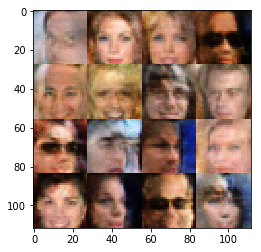

Epoch 0/1... Discriminator Loss: 1.1310... Generator Loss: 0.7371
Epoch 0/1... Discriminator Loss: 1.4439... Generator Loss: 0.4566
Epoch 0/1... Discriminator Loss: 1.1767... Generator Loss: 0.7437
Epoch 0/1... Discriminator Loss: 0.8029... Generator Loss: 1.2656
Epoch 0/1... Discriminator Loss: 1.4228... Generator Loss: 0.4692
Epoch 0/1... Discriminator Loss: 1.1562... Generator Loss: 1.4549
Epoch 0/1... Discriminator Loss: 1.1947... Generator Loss: 0.6174
Epoch 0/1... Discriminator Loss: 1.5298... Generator Loss: 0.4068
Epoch 0/1... Discriminator Loss: 1.2632... Generator Loss: 0.8667
Epoch 0/1... Discriminator Loss: 0.8184... Generator Loss: 1.4216
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


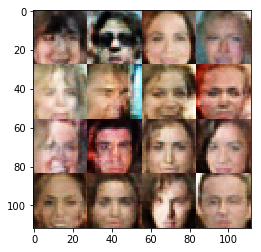

Epoch 0/1... Discriminator Loss: 1.0396... Generator Loss: 0.8791
Epoch 0/1... Discriminator Loss: 1.2512... Generator Loss: 0.6325
Epoch 0/1... Discriminator Loss: 1.6260... Generator Loss: 0.3737
Epoch 0/1... Discriminator Loss: 1.0867... Generator Loss: 0.9257
Epoch 0/1... Discriminator Loss: 0.9906... Generator Loss: 2.0106
Epoch 0/1... Discriminator Loss: 0.8171... Generator Loss: 1.1114
Epoch 0/1... Discriminator Loss: 0.9892... Generator Loss: 0.8269
Epoch 0/1... Discriminator Loss: 0.9483... Generator Loss: 0.9412
Epoch 0/1... Discriminator Loss: 1.0926... Generator Loss: 1.8247
Epoch 0/1... Discriminator Loss: 0.9334... Generator Loss: 1.1693
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


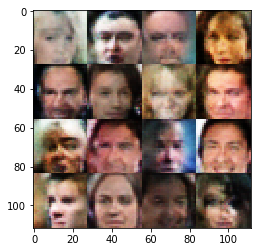

Epoch 0/1... Discriminator Loss: 1.5926... Generator Loss: 0.3994
Epoch 0/1... Discriminator Loss: 1.3129... Generator Loss: 3.4118
Epoch 0/1... Discriminator Loss: 0.9516... Generator Loss: 1.1070
Epoch 0/1... Discriminator Loss: 0.9705... Generator Loss: 0.9356
Epoch 0/1... Discriminator Loss: 0.8294... Generator Loss: 1.0533
Epoch 0/1... Discriminator Loss: 1.0769... Generator Loss: 0.7796
Epoch 0/1... Discriminator Loss: 0.7541... Generator Loss: 1.4230
Epoch 0/1... Discriminator Loss: 1.5480... Generator Loss: 0.5610
Epoch 0/1... Discriminator Loss: 1.0967... Generator Loss: 2.3184
Epoch 0/1... Discriminator Loss: 1.0330... Generator Loss: 0.8150
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


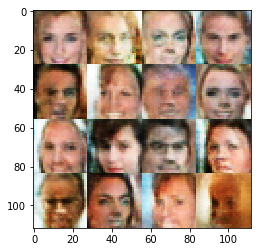

Epoch 0/1... Discriminator Loss: 0.8452... Generator Loss: 1.4617
Epoch 0/1... Discriminator Loss: 1.0573... Generator Loss: 0.8195
Epoch 0/1... Discriminator Loss: 1.1454... Generator Loss: 2.1027
Epoch 0/1... Discriminator Loss: 1.5269... Generator Loss: 0.4294
Epoch 0/1... Discriminator Loss: 0.8611... Generator Loss: 1.1057
Epoch 0/1... Discriminator Loss: 1.2284... Generator Loss: 0.6629
Epoch 0/1... Discriminator Loss: 0.9662... Generator Loss: 0.9037
Epoch 0/1... Discriminator Loss: 0.9003... Generator Loss: 1.7718
Epoch 0/1... Discriminator Loss: 1.2838... Generator Loss: 0.5551
Epoch 0/1... Discriminator Loss: 1.3837... Generator Loss: 0.4900
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


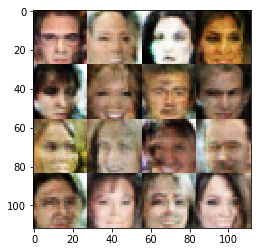

Epoch 0/1... Discriminator Loss: 1.0678... Generator Loss: 0.8072
Epoch 0/1... Discriminator Loss: 0.8487... Generator Loss: 1.1333
Epoch 0/1... Discriminator Loss: 1.1603... Generator Loss: 0.6839
Epoch 0/1... Discriminator Loss: 0.8634... Generator Loss: 1.3624
Epoch 0/1... Discriminator Loss: 1.0705... Generator Loss: 0.8324
Epoch 0/1... Discriminator Loss: 1.7332... Generator Loss: 0.3444
generator shape (?, 4, 4, 512) (?, 8, 8, 256) (?, 16, 16, 128) (?, 28, 28, 3)


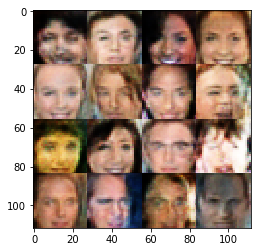

In [27]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.